In [ ]:
# Recreating HI power spectrum and measurement errors from SKA-low

In [207]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import camb
from camb import model, initialpower
from scipy import integrate
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import bisect
from scipy.interpolate import interp1d
import scipy
from matplotlib import gridspec

In [3]:
# Setting cosmology to Planck 2015 TT, TE, EE + lowP cosmological parameters
m_nu = [0.0, 0.0, 0.06] * u.eV
cosmo = FlatLambdaCDM(H0 = 67.27 * u.km / u.s / u.Mpc, Om0=0.3156, Neff= 3.0, m_nu=m_nu, Ob0=0.0492)

In [4]:
# Cosmological constants (Planck 2015 TTTEEE+lowP):

h = 0.6727
c_Mpc = 9.7156140203724e-15 # Mpc per second
c_km = 3e5 # km per second
c_m = 3e8 # m per second
Ob0 = 0.0492
Om0 = 0.3156
Oc0 = Om0-Ob0
ns = 0.9645
As = 2.207e-9

In [19]:
# Functions:

def Pm(z, kmax, kmin):
    """Constructing matter power spectrum from CAMB
    Args:
        z: redshift of desired matter power spectrum
        kmax: maximum wavevector, Mpc
        kmin: minimum wavevector, Mpc
    Returns:
        k: wavevector range, Mpc
        pk: matter power spectrum, Mpc^3/h^-3
        z1: redshift of power spectrum (input)"""
    #Setting parameters:
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=h*100, ombh2=Ob0*h*h, omch2=Oc0*h*h, omk=0, mnu=0) # setting cosmology, Planck 15 TTTEEE+lowp
    pars.set_dark_energy() #LCDM (default)
    pars.InitPower.set_params(ns=ns, r=0, As=As) # setting initial matter power spectrum
    pars.set_for_lmax(2500, lens_potential_accuracy=0)
    #Get matter power spectrum at z
    pars.set_matter_power(redshifts=[z], kmax=2.0)
    pars.NonLinear = model.NonLinear_both # Non-Linear spectra (Halofit)
    results = camb.get_results(pars)
    results.calc_power_spectra(pars)
    kh, z1, pkh = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 16000000)
    return kh*h, pkh[0]/pow(h,3)

def PHI(p, zc):
    """Obtaining HI power spectrum, neglecting RSDs
    Args:
        Pk_z0: matter power spectrum P(k,z), Mpc^3
        kk: wavenumber
        zc: central redshift
    Returns:
        HI power spectrum, mK^2 Mpc^3"""
    return pow(b_HI(zc),2)*pow(T_HI(zc),2)*p
    
def P_Nperp(c_1, c_2, z, Asky, f0, Ddish, Dmax, t_tot, Nd):
    """Calculating Noise power spectrum (not integrated over mu!)
    Args:
        c_1: speed of light, m/s
        c_2: speed of light, km/s
        z: redshift
        Asky: area of sky probed by survey, deg^2
        f0: frequency, Hz
        Ddish: station size, m
        Dmax: maximum baseline of core configuration, m
        t_tot: total observing time, s
        Nd: number of stations
    Returns:
        Noise power spectrum, mK^2 Mpc^3"""
    P_N1 = (T_sys(z)**2)*Omega_tot(Asky)*(r(z)**2)*y_nu(c_2, z, f0)*FOV(z, Ddish)
    P_N2 = n_d(Nd, z, Dmax, Ddish)*t_tot
    return P_N1/P_N2

def errPHI(c, zmin, zmax, Asky, k, deltak, phi, pn):
    """Obtaining error HI power spectrum
    Args:
        c: speed of light, km/s
        zmin: minimum redshift in redshift bin
        zmax: maximum redshift in redshift bin
        Asky: area of sky probed by survey, deg^2
        k: wavevector range, Mpc
        deltak: wavevector binning, Mpc
        phi: HI power spectrum, mK^2 Mpc^3
        pn: noice power spectrum, mK^2 Mpc^3
    Returns:
        error in HI power spectrum, mK^2 Mpc^3"""
    inside = (2*(2*np.pi)**3)/(V_sur(c, zmin, zmax, Asky)*4*np.pi*k*k*deltak)
    return np.sqrt(inside)*(phi + pn)

def r(z):
    """Calculating comoving distance to redshift z
    Args:
        z: redshift
    Returns:
        comoving distance, Mpc"""
    return cosmo.comoving_distance([z]).value[0]

def V_sur(c, zmin, zmax, Asky):
    """Calculating volume of a survey
    Args:
        c: speed of light, km/s
        zmin: minimum redshift in redshift bin
        zmax: maximum redshift in redshift bin
        Asky: area of sky probed by survey, deg^2
    Returns:
        Survey volume, sr"""
    V_sur_integrand = lambda z: (c*r(z)*r(z))/H(z)
    integral = integrate.quad(V_sur_integrand, zmin, zmax)[0]
    return Omega_tot(Asky)*integral

def H(z):
    """Calculating Hubble constant at a redshift z
    Args:
        z: redshift
    Returns:
        Hubble constant, km / Mpc s"""
    return cosmo.H([z]).value[0]

def lambda_m(z):
    """Calculating wavelength of observation at redshift z
    Args:
        z: redshift
    Returns:
        wavelength, m"""
    return 21*(1 + z)*0.01 # 0.01 is to convert from cm to m

def f_MHz(c, z):
    """Calculating frequency of observation at redshift z
    Args:
        c: speed of light, m/s
        z: redshift
    Returns:
        frequency, MHz"""
    return (c/lambda_m(z))/10**6

def k_min(z, Ddish):
    """Calculating minimum wavevector at redshift z
    Args:
        z: redshift
        Ddish: station size, m
    Returns:
        minimum wavevector, Mpc"""
    Ddish = Ddish*3.24078e-23 # in Mpc instead of m
    return (2*np.pi*Ddish)/(r(z)*lambda_m(z)*3.24078e-23)

def k_max(z, Dmax):
    """Calculating minimum wavevector at redshift z
    Args:
        z: redshift
        Dmax: maximum baseline of core configuration, m
    Returns:
        minimum wavevector, Mpc"""
    Dmax = Dmax*3.24078e-23 # in Mpc instead of m
    return (2*np.pi*Dmax)/(r(z)*lambda_m(z)*3.24078e-23)

def T_HI(z):
    """Calculating HI background temperature at redshift z
    Args:
        z: redshift
    Returns:
        HI background temperature, mK"""
    return 0.0559 + 0.2324*z - 0.024*z*z

def b_HI(z):
    """Calculating HI bias at redshift z
    Args:
        z: redshift
    Returns:
        HI bias"""
    return 0.67 + 0.18*z + 0.05*z*z

def Omega_HI(z):
    """Calculating HI abundance at redshift z
    Args:
        z: redshift
    Returns:
        HI abundance"""
    return 0.00048 + 0.00039*z - 0.000065*z*z

def FOV(z, Ddish):
    """Calculating FOV (instantaneous field of view) at redshift z
    Args:
        z: redshift
        Ddish: station size, m
    Returns:
        FOV"""
    return ((1.22*lambda_m(z))/Ddish)**2

def Omega_tot(Asky):
    """Calculating total section of sky scanned by survey
    Args:
        Asky: area of sky probed by survey, deg^2
    Returns:
        Omega total, sr"""
    return Asky*(np.pi/180)**2

def y_nu(c, z, f0):
    """Calculating ynu
    Args:
        c: speed of light, km/s
        z: redshift
        f0: frequency, Hz
    Returns:
        ynu, Mpc s"""
    return (c*((1+z)**2))/(f0*H(z))

def n_d(Nd, z, Dmax, Ddish):
    """Calculating nd
    Args:
        Nd: number of stations
        z: redshift
        Ddish: station size, m
        Dmax: maximum baseline of core configuration, m
    Returns:
        nd"""
    ndA = Nd*(Nd - 1)*lambda_m(z)*lambda_m(z)
    ndB = 2*np.pi*(Dmax*Dmax - Ddish*Ddish)
    return ndA/ndB

def T_sys(z):
    """Calculating overall system temperature of instrument
    Args:
        z: redshift
    Returns:
        system temperature, mK"""
    fc = 1420.4/(1+z) # frequency
    Tgal = 25*((408/fc)**(2.75))
    return (0.1*Tgal + 40 + Tgal)*1000

In [110]:
# Constants for SKA:

Ddish_ska = 35 # meters
Dmax_ska = 1000 # meters
Asky_ska = 100 # square degrees
f0_ska = 1420.4e6 # mid frequency, in Hertz
t_ska = 5000*60*60 # seconds
Nd_ska = 224 # stations
kmin_ska = k_min(4.00, 35) # lower limit
kmax_ska = 0.2*h # strict non-linear cut off, conservative
kmax_skar = k_max(4.00, 1000) # realistic instrumental cut off
z_ska = 4.00
zmin_ska = 3.85 # bin size 0.3
zmax_ska = 4.15 # bin size 0.3

Steps:

1. Obtain matter power spectrum at z = 4 using CAMB

2. Calculate HI power spectrum at z=4, neglecting RSDs

3. Calculate HI power spectrum at z=4, including RSDs

4. Calculate noise power spectrum

5. Estimate error in HI power spectrum and plot alongside HI power spectrum

## Step 1: Matter Power Spectrum

Minimum and maximum wavevectors:

$$ k_{min} = \frac{2 \pi D_{dish}}{r \lambda} $$

$$ k_{max,cons} = 0.2h / Mpc $$

$$ k_{max,real} = \frac{2 \pi D_{max}}{r \lambda} $$

where:

$r$ = comoving distance to redshift z

$D_{dish}$ = 35 m

$D_{max}$ = 1000 m

$\lambda$ = 21(1 + z) cm

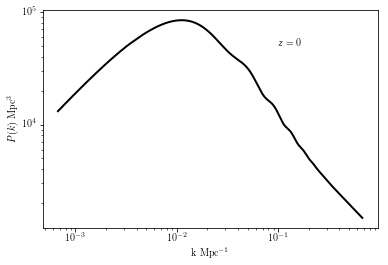

In [205]:
# Testing, matter power spectrum at z=0:
k0, Pm0 = Pm(0.0, 1.0, 1e-3)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(6, 4))
plt.plot(k0,Pm0, color='black',lw=2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('k Mpc$^{-1}$')
plt.ylabel('$P(k)$ Mpc$^{3}$')
plt.text(0.1, 5e4, '$z=0$')
plt.savefig('PowerSpectrumz0.pdf', format='pdf', dpi=300, transparent=False)

### Conservative k_max:

In [8]:
# Obtaining matter power spectrum:
k4, Pm_4 = Pm(z_ska, kmax_ska/h, kmin_ska/h)

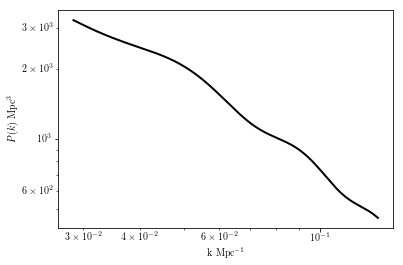

In [88]:
plt.plot(k4, Pm_4, color='k', ls = '-', lw=2)
plt.xlabel('k Mpc$^{-1}$')
plt.ylabel('$P(k)$ Mpc$^{3}$')
plt.yscale('log')
plt.xscale('log')
#plt.text(0.1, 2e3, '$z=4$')
plt.savefig('PowerSpectrumz4.pdf', format='pdf', dpi=300, transparent=False)

### Realistic k_max:

In [24]:
k4r, Pm_4r = Pm(z_ska, kmax_skar/h, kmin_ska/h)

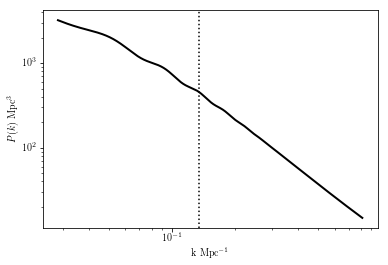

In [194]:
plt.plot(k4r, Pm_4r, color='k', ls = '-', lw=2)
plt.xlabel('k Mpc$^{-1}$')
plt.axvline(x=kmax_ska, color='k', linestyle=':')
plt.ylabel('$P(k)$ Mpc$^{3}$')
plt.yscale('log')
plt.xscale('log')
#plt.text(0.1, 2e3, '$z=4$')
plt.savefig('PowerSpectrumz4R.pdf', format='pdf', dpi=300, transparent=False)

## Step 2: HI power spectrum neglecting RSDs:

$$ P_{HI}(k,z) = \bar T_{HI}^{2} b_{HI}^{2} P(k, z) $$

Where, from Bull et al. 2015:

$$ b_{HI} = 0.67 + 0.18z + 0.05z^{2} $$

$$ \bar T_{HI} = 0.0559 + 0.2324z - 0.024z^{2} mK $$

$$ \Omega_{HI} = 0.00048 + 0.00039z - 0.000065z^{2} $$

### Conservative k_max:

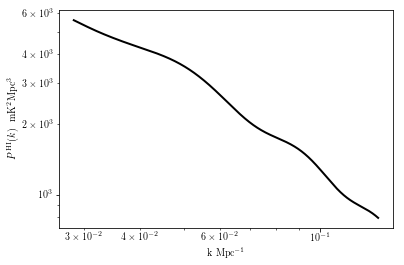

In [86]:
P_HI = PHI(Pm_4, 4.0)
plt.loglog(k4, P_HI, color='k', ls = '-', lw=2)
plt.xlabel('k Mpc$^{-1}$')
plt.ylabel("$P^{\, \mathrm{HI}}(k)\, $  $\, \mathrm{mK^2 Mpc^3}$")
plt.savefig('PowerSpectrumz4HI.pdf', format='pdf', dpi=300, transparent=False)

### Realistic k_max:

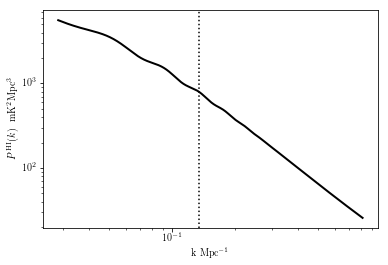

In [195]:
P_HIr = PHI(Pm_4r, 4.0)
plt.loglog(k4r, P_HIr, color='k', ls = '-', lw=2)
plt.axvline(x=kmax_ska, color='k', linestyle=':')
plt.xlabel('k Mpc$^{-1}$')
plt.ylabel("$P^{\, \mathrm{HI}}(k)\, $  $\, \mathrm{mK^2 Mpc^3}$")
plt.savefig('PowerSpectrumz4HIR.pdf', format='pdf', dpi=300, transparent=False)

## Step 4: Noise power spectrum

$$ P^{N}(k) = \frac{T_{sys}^{2} \Omega_{tot} r^{2} y_{\nu} FOV }{n(d) t_{total}} $$

where:

$T_{sys} = T_{inst} + T_{sky} $

$\Omega_{tot}$ is survey sky area in steradians

$r$ is comoving distance to redshift z

$y_{\nu} = \frac{c(1+z)^{2}}{f_{0}H(z)}$

$f_{0}$ = 1420 MHz

$FOV = (1.22\lambda/D_{dish})^{2} $

$n(d) = \frac{ N_{d}(N_{d} - 1)\lambda^{2} }{2\pi(D_{max}^{2} - D_{dish}^{2})}$

$N_{d}$ = 224 stations

$D_{max}$ = 1 km

In [36]:
# Calculating uniform noise power spectrum:
P_N = P_Nperp(c_m, c_km, z_ska, Asky_ska, f0_ska, Ddish_ska, Dmax_ska, t_ska, Nd_ska)
print(P_N)

2258.8441500995573


### Conservative k_max:

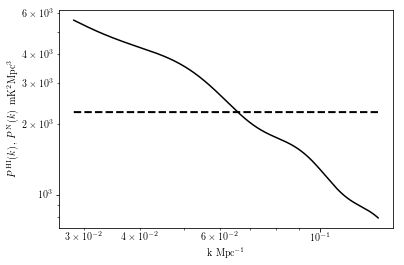

In [90]:
pn = [P_N for k in k4]

plt.plot(k4,pn,color='black',lw=2, ls='dashed')
plt.plot(k4, P_HI, color='k', ls = '-')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("k $\mathrm{Mpc^{-1}}$")
plt.ylabel("$P^{\, \mathrm{HI}}(k)\, $, $P^{\, \mathrm{N}}(k)$   $\, \mathrm{mK^2 Mpc^3}$")
#plt.text(0.1, 4e3, '$z=4$')
plt.savefig('PowerSpectrumz4HIN01.pdf', format='pdf', dpi=300, transparent=False)

### Realistic k_max:

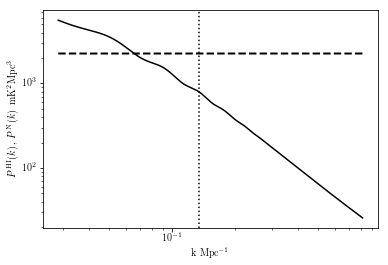

In [196]:
pnr = [P_N for k in k4r]

plt.axvline(x=kmax_ska, color='k', linestyle=':')
plt.plot(k4r,pnr,color='black',lw=2, ls='dashed')
plt.plot(k4r, P_HIr, color='k', ls = '-')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("k $\mathrm{Mpc^{-1}}$")
plt.ylabel("$P^{\, \mathrm{HI}}(k)\, $, $P^{\, \mathrm{N}}(k)$   $\, \mathrm{mK^2 Mpc^3}$")
#plt.text(0.1, 4e3, '$z=4$')
plt.savefig('PowerSpectrumz4HIN01R.pdf', format='pdf', dpi=300, transparent=False)

### Step 5a: Error in power spectrum neglecting RSDs

In [42]:
# Finding indices of where new k arrays fit in with original k array, in order to extract power spectrum
# bisect_left is used to get indices (bisect_right is not suitable because it yields index+1)

k1 = np.arange(kmin_ska+(0.01/2), kmax_ska-(0.01/2), 0.01)
indk1=np.full(len(k1),0)
for i in range(0, len(k1)):
    indk1[i] = bisect.bisect_left(k4,k1[i])
k5 = np.arange(kmin_ska+(0.05/2), kmax_ska-(0.05/2), 0.05)
indk5=np.full(len(k5),0)
for i in range(0, len(k5)):
    indk5[i] = bisect.bisect_left(k4,k5[i])

# Retrieving shortened power spectrum that fits with new k arrays
PHI1 = P_HI[indk1]
PHI5 = P_HI[indk5]

# Calculating error in power spectrum
errP_HI1 = errPHI(c_km, zmin_ska, zmax_ska, Asky_ska, k1, 0.01, PHI1, P_N)
errP_HI5 = errPHI(c_km, zmin_ska, zmax_ska, Asky_ska, k5, 0.05, PHI5, P_N)

In [43]:
print(k1, k4[indk1]) # checking they match

[0.03352534 0.04352534 0.05352534 0.06352534 0.07352534 0.08352534
 0.09352534 0.10352534 0.11352534 0.12352534] [0.03352535 0.04352534 0.05352534 0.06352535 0.07352535 0.08352535
 0.09352535 0.10352535 0.11352535 0.12352535]


### Conservative k_max

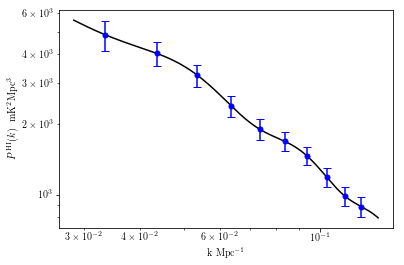

In [44]:
plt.errorbar(k1, PHI1, yerr=errP_HI1, fmt='bo', capsize=4, markersize=5)
plt.plot(k4, P_HI, c='k')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("k $\mathrm{Mpc^{-1}}$")
plt.ylabel("$P^{\, \mathrm{HI}}(k)\,$ $\, \mathrm{mK^2 Mpc^3}$")

plt.savefig('PHI_error_k01.pdf', format='pdf', dpi=300, transparent=False)

In [45]:
SN1 = np.zeros(len(k1))
for i in range(len(k1)):
    SN1[i] = (PHI1[i]/errP_HI1[i])**2
SN1 = np.cumsum(SN1)
SN1 = np.sqrt(SN1)
print(SN1)

[ 6.77516095 10.69042746 14.21017799 17.21640094 19.90056873 22.5515159
 25.05751751 27.1984909  29.0580297  30.84110949]


In [47]:
# Adjusting steps to fit plotting function better
k1steps = np.append(k1, k1[-1]+0.01)
k1steps = k1steps - 0.005
SN1steps = np.append(SN1, SN1[-1])

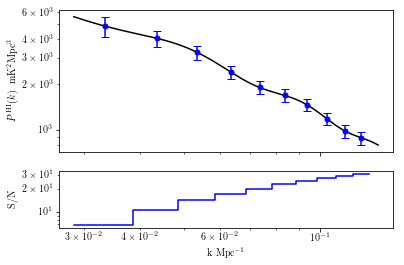

In [48]:
fig, ax = plt.subplots(2, sharex=True, gridspec_kw = {'height_ratios':[5, 2]})
ax[0].plot(k4, P_HI, c='k')
ax[0].errorbar(k1, PHI1, yerr=errP_HI1, fmt='bo', capsize=4, markersize=5)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylabel("$P^{\, \mathrm{HI}}(k)\,$ $\, \mathrm{mK^2 Mpc^3}$")
ax[1].step(k1steps, SN1steps, where='post',c='b')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylabel("S/N")
ax[1].set_xlabel("k $\mathrm{Mpc^{-1}}$")
plt.savefig('PHI_SN.pdf', format='pdf', dpi=300, transparent=False)

### Realistic k_max

In [198]:
k1r = np.arange(kmin_ska+(0.01/2), kmax_skar-(0.01/2), 0.01)
indk1r=np.full(len(k1r),0)
for i in range(0, len(k1r)):
    indk1r[i] = bisect.bisect_left(k4r,k1r[i])
PHI1r = P_HIr[indk1r]
errP_HI1r = errPHI(c_km, zmin_ska, zmax_ska, Asky_ska, k1r, 0.01, PHI1r, P_N)

In [199]:
SN1r = np.zeros(len(k1r))
for i in range(len(k1r)):
    SN1r[i] = (PHI1r[i]/errP_HI1r[i])**2
SN1r = np.cumsum(SN1r)
SN1r = np.sqrt(SN1r)

In [200]:
# Adjusting steps to fit plotting function better
k1stepsr = np.append(k1r, k1r[-1]+0.01)
k1stepsr = k1stepsr - 0.005
SN1stepsr = np.append(SN1r, SN1r[-1])

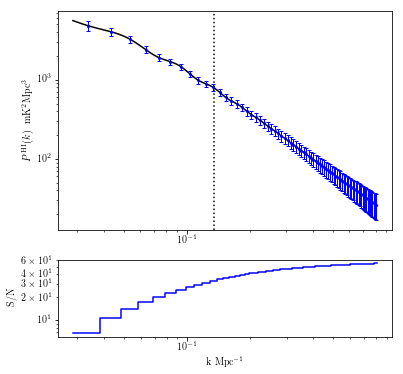

In [218]:
fig = plt.figure(figsize=(6, 6)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[8, 2.8]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax0.plot(k4r, P_HIr, c='k')
ax0.axvline(x=kmax_ska, color='k', linestyle=':')
ax0.errorbar(k1r, PHI1r, yerr=errP_HI1r, fmt='bo', capsize=2, markersize=2, elinewidth=1, capthick=1)
ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.set_ylabel("$P^{\, \mathrm{HI}}(k)\,$ $\, \mathrm{mK^2 Mpc^3}$")
ax1.step(k1stepsr, SN1stepsr, where='post',c='b')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel("S/N")
ax1.set_xlabel("k $\mathrm{Mpc^{-1}}$")
plt.savefig('PHI_SNR.pdf', format='pdf', dpi=300, transparent=False)

In [34]:
## checking same result for deltak = 0.05

SN5 = np.zeros(len(k5))
for i in range(len(k5)):
    SN5[i] = (PHI5[i]/errP_HI5[i])**2
SN5 = np.cumsum(SN5)
SN5 = np.sqrt(SN5)
print(SN5)

[20.93369523 31.58501565]


## Optimisation study

In [58]:
# Area: 100 - 10000 deg^2
# Time: 100 - 10000 hrs

In [59]:
Areas = np.arange(100, 10100, 100)
Times = np.arange(100, 10100, 100)
print(len(Areas), len(Times))

100 100


### Conservative k_max

In [61]:
errPHIopt = [[]]
for i in range(len(Areas)):
    for j in range(len(Times)):
        errPHIopt.append(errPHI(c_km, zmin_ska, zmax_ska, Areas[i], k1, 0.01, PHI1, 
                                P_Nperp(c_m, c_km, z_ska, Areas[i], f0_ska, Ddish_ska, 
                                        Dmax_ska, Times[j]*60*60, Nd_ska)))
print(len(errPHIopt))

10001


In [63]:
SNopt = []
# start from 1 because first element of errPHIopt is empty
for i in range(1,len(errPHIopt)):
    # note: we do not perform full cumulative sum, only total sum since we are interested in total value
    SNopt.append(np.sum((PHI1/errPHIopt[i])**2))
SNopt = np.sqrt(SNopt)
print(max(SNopt))
print(SNopt[1])

43.61591531874209
2.29614024255171


In [68]:
data = SNopt
shape = (100,100)
data = data.reshape(shape)

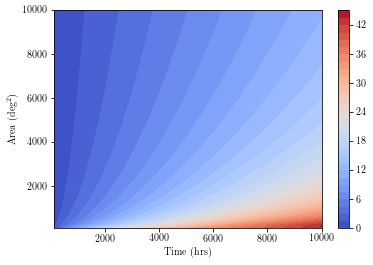

In [237]:
fig, ax = plt.subplots()
CS = ax.contourf(Times, Areas, data, 30, cmap='coolwarm')
plt.colorbar(CS)
ax.set_xlabel('Time (hrs)')
ax.set_ylabel('Area (deg$^{2}$)')
plt.savefig('contour.pdf', format='pdf', dpi=300, transparent=False)

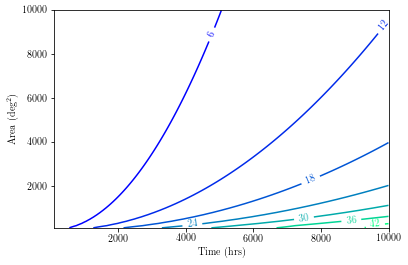

In [266]:
fig, ax = plt.subplots()
CS = ax.contour(Times, Areas, data, cmap='winter')
ax.clabel(CS, fmt='%1.0f')
ax.set_xlabel('Time (hrs)')
ax.set_ylabel('Area (deg$^{2}$)')
plt.savefig('contour2.pdf', format='pdf', dpi=300, transparent=False)

### Realistic k_max

In [248]:
errPHIoptr = [[]]
for i in range(len(Areas)):
    for j in range(len(Times)):
        errPHIoptr.append(errPHI(c_km, zmin_ska, zmax_ska, Areas[i], k1r, 0.01, PHI1r, 
                                P_Nperp(c_m, c_km, z_ska, Areas[i], f0_ska, Ddish_ska, 
                                        Dmax_ska, Times[j]*60*60, Nd_ska)))
print(len(errPHIoptr))

10001


In [249]:
SNoptr = []
# start from 1 because first element of errPHIopt is empty
for i in range(1,len(errPHIoptr)):
    # note: we do not perform full cumulative sum, only total sum since we are interested in total value
    SNoptr.append(np.sum((PHI1r/errPHIoptr[i])**2))
SNoptr = np.sqrt(SNoptr)
print(max(SNoptr))
print(SNoptr[1])

93.32207904160528
3.0746892331350613


In [250]:
datar = SNoptr
shaper = (100,100)
datar = datar.reshape(shaper)

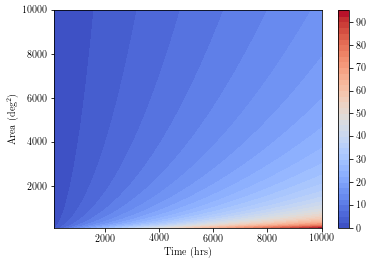

In [262]:
fig, ax = plt.subplots()
CSr = ax.contourf(Times, Areas, datar, 40, cmap='coolwarm')
plt.colorbar(CSr)
ax.set_xlabel('Time (hrs)')
ax.set_ylabel('Area (deg$^{2}$)')
plt.savefig('contourr.pdf', format='pdf', dpi=300, transparent=False)

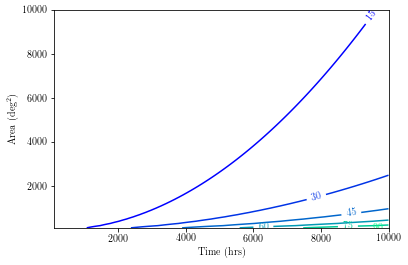

In [265]:
fig, ax = plt.subplots()
CS = ax.contour(Times, Areas, datar, cmap='winter')
ax.clabel(CS, fmt='%1.0f')
ax.set_xlabel('Time (hrs)')
ax.set_ylabel('Area (deg$^{2}$)')
plt.savefig('contourr2.pdf', format='pdf', dpi=300, transparent=False)

In [ ]:
# Plotting both results together:

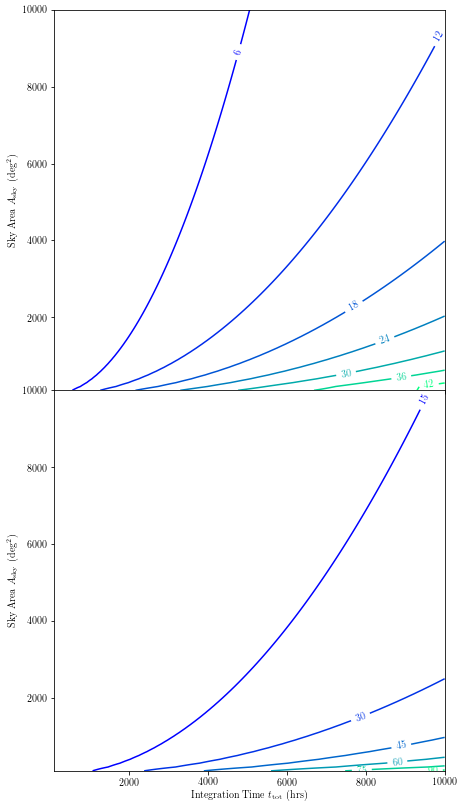

In [288]:
fig, ax = plt.subplots(nrows=2, sharex=True,figsize=(7,14))
CS0 = ax[0].contour(Times, Areas, data, cmap='winter')
ax[0].clabel(CS0, fmt='%1.0f')
ax[0].set_ylabel('Sky Area $A_{\mathrm{sky}}$ (deg$^{2}$)')
CS1 = ax[1].contour(Times, Areas, datar, cmap='winter')
ax[1].clabel(CS1, fmt='%1.0f')
ax[1].set_xlabel('Integration Time $t_{\mathrm{tot}}$ (hrs)')
ax[1].set_ylabel('Sky Area $A_{\mathrm{sky}}$ (deg$^{2}$)')
fig.subplots_adjust(hspace=0)
plt.savefig('contour_both.pdf', format='pdf', dpi=300, transparent=False)